In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

In [3]:
df2 = pd.read_csv('clean_new_well_data_fixed.csv')

In [4]:
df = pd.read_excel('AASG_Thermed_AllThicksAndConds.xlsx')

In [5]:
def outlierDrop(df,df_toCheck,std_cut_off):
    init_len = df.shape[0]
    for i in df_toCheck:
        mean = df[i].mean()
        std = df[i].std()
        cut_off = std * std_cut_off
        lower, upper =mean - cut_off, mean + cut_off
        df = df[(df[i] < upper) & (df[i] > lower)]
    print("numbere of outliers removed: ", init_len - df.shape[0])
    return df
#df = outlierDrop(df,['CorrBHT', 'HeatFlow','MeasureDepth_m'],4)
df = outlierDrop(df,['HeatFlow'],3)
df = df[df['HeatFlow']>0]

numbere of outliers removed:  67


In [6]:
df.reset_index(inplace=True, drop=True)

In [7]:
df2

,id,depth,temp,lat,lon,corrtemp
0,4703502978,671.1696,23.648778,38.787043,-81.805252,26.034804
1,4703502978,671.3220,23.646333,38.787043,-81.805252,26.033353
2,4703502978,671.4744,23.643444,38.787043,-81.805252,26.031458
3,4703502978,671.6268,23.640278,38.787043,-81.805252,26.029285
4,4703502978,671.7792,23.636778,38.787043,-81.805252,26.026778
...,...,...,...,...,...,...
582743,4710300645,2021.9670,56.438889,39.678222,-80.823766,67.632114
582744,4710300645,2022.0432,56.444444,39.678222,-80.823766,67.638166
582745,4710300645,2022.1194,56.444444,39.678222,-80.823766,67.638663
582746,4710300645,2022.1956,56.444444,39.678222,-80.823766,67.639160


# Find Closest Points for Estimation with Phys Model

1. Get Random 100 points from df2

In [62]:
num_sample=10000
sampled_df2 = df2.sample(num_sample)

In [63]:
import math
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [64]:
# Round by 10 to later compare with T1~T500
sampled_df2.depth = np.round(sampled_df2.depth,decimals=-1).astype('int')

In [65]:
sampled_df2

,id,depth,temp,lat,lon,corrtemp
333687,4708509402,750,37.794444,39.102880,-80.842275,40.676301
230415,4704102039,1010,43.677778,39.104547,-80.645929,48.270199
495803,4707700185,2220,60.355556,39.562450,-79.746017,72.814191
93677,4700502146,1290,44.094444,37.976735,-81.878142,50.493815
350598,4704701120,1240,24.205556,37.478631,-81.862642,30.300373
...,...,...,...,...,...,...
370189,4704700115,1110,34.533333,37.276976,-81.683570,39.755231
490971,4707700185,1480,38.555556,39.562450,-79.746017,46.212884
39885,4701900241,390,25.088889,38.113789,-80.984939,25.662998
59898,4701900241,1920,64.238889,38.113789,-80.984939,74.755936


In [66]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])))
pred_indices = neigh.kneighbors(np.transpose(np.array([sampled_df2.lat,sampled_df2.lon])),return_distance=False)

In [67]:
sampled_df2.insert(6, 'closest',pred_indices)

In [68]:
sampled_df2.reset_index(inplace=True)

In [69]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest
0,333687,4708509402,750,37.794444,39.102880,-80.842275,40.676301,19496
1,230415,4704102039,1010,43.677778,39.104547,-80.645929,48.270199,18456
2,495803,4707700185,2220,60.355556,39.562450,-79.746017,72.814191,19036
3,93677,4700502146,1290,44.094444,37.976735,-81.878142,50.493815,16547
4,350598,4704701120,1240,24.205556,37.478631,-81.862642,30.300373,18866
...,...,...,...,...,...,...,...,...
9995,370189,4704700115,1110,34.533333,37.276976,-81.683570,39.755231,18888
9996,490971,4707700185,1480,38.555556,39.562450,-79.746017,46.212884,19036
9997,39885,4701900241,390,25.088889,38.113789,-80.984939,25.662998,17296
9998,59898,4701900241,1920,64.238889,38.113789,-80.984939,74.755936,17296


In [70]:
predicted_values_by_physics_model = []
for i in range(0, num_sample):
    curr_depth = sampled_df2.depth[i]
    curr_row = df.loc[sampled_df2.closest[i]] # obtain the row
    t_string = 'T'+str(int(curr_depth/10))
    predicted_value = curr_row[t_string]
    predicted_values_by_physics_model.append(predicted_value)

In [71]:
predicted_values_by_physics_model = np.array(predicted_values_by_physics_model)

In [72]:
sampled_df2.insert(8, 'physics_pred', predicted_values_by_physics_model)

In [73]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred
0,333687,4708509402,750,37.794444,39.102880,-80.842275,40.676301,19496,28.883461
1,230415,4704102039,1010,43.677778,39.104547,-80.645929,48.270199,18456,41.024600
2,495803,4707700185,2220,60.355556,39.562450,-79.746017,72.814191,19036,75.532555
3,93677,4700502146,1290,44.094444,37.976735,-81.878142,50.493815,16547,48.634886
4,350598,4704701120,1240,24.205556,37.478631,-81.862642,30.300373,18866,36.151254
...,...,...,...,...,...,...,...,...,...
9995,370189,4704700115,1110,34.533333,37.276976,-81.683570,39.755231,18888,43.237835
9996,490971,4707700185,1480,38.555556,39.562450,-79.746017,46.212884,19036,52.059915
9997,39885,4701900241,390,25.088889,38.113789,-80.984939,25.662998,17296,21.070813
9998,59898,4701900241,1920,64.238889,38.113789,-80.984939,74.755936,17296,44.090080


# Add Geological Information

- Predict: Geological information of sampled_df2, cond1*thick1 + ...

In [74]:
lat_to_interpolate = sampled_df2.lat
lon_to_interpolate = sampled_df2.lon

In [75]:
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)
mult.shape

(20649, 49)

In [76]:
# Read optimal values
f = open("optim_result.out", "r")
lines = f.readlines()

In [77]:
optimal_neigh = []
optimal_width = []
for line in lines:
    optimal_neigh.append(line.split(',')[0][0])
    optimal_width.append(line.split(',')[1])
optimal_neigh = np.array(optimal_neigh).astype('int')
optimal_width = np.array(optimal_width).astype('float')

In [78]:
# Predict 49 layers information for each sampled_df2 lat and lon
from sklearn.neighbors import KNeighborsRegressor
predicted_mults = []
for i in range(0,49):
    def gaussian_kernel(distances):
                kernel_width = optimal_width[i]
                weights = np.exp(-(distances**2)/kernel_width)
                return weights
    knn = KNeighborsRegressor(n_neighbors=optimal_neigh[i],weights=gaussian_kernel)
    #knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
    knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), mult[:,i])
    y_pred = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))
    predicted_mults.append(y_pred)

In [79]:
predicted_mults = np.transpose(np.array(predicted_mults))

In [80]:
# Predict T_SURF
def gaussian_kernel(distances):
            kernel_width = 2.598
            weights = np.exp(-(distances**2)/kernel_width)
            return weights
knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), df.SurfTemp)
predicted_tsurf = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))

# Prediction with XGB

In [81]:
import xgboost as xgb

In [82]:
gbm = xgb.XGBRegressor(learning_rate=0.01,  
                           objective='reg:squarederror', 
                           n_estimators=2000, 
                           reg_alpha=1,
                           reg_lambda=10,
                           max_depth=10, 
                           gamma=0.1)
X_train = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
y_train = df.CorrBHT.values

In [83]:
X_train = np.concatenate((X_train, mult),axis=1)

In [84]:
gbm.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=10, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
X_test = np.transpose(np.array([sampled_df2.lat,
                               sampled_df2.lon,
                               sampled_df2.depth,
                               predicted_tsurf]))
X_test = np.concatenate((X_test, predicted_mults),axis=1)
y_pred = gbm.predict(X_test)

In [86]:
sampled_df2.insert(9, 'gbm_pred', y_pred)

In [87]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,gbm_pred
0,333687,4708509402,750,37.794444,39.102880,-80.842275,40.676301,19496,28.883461,25.588156
1,230415,4704102039,1010,43.677778,39.104547,-80.645929,48.270199,18456,41.024600,32.472488
2,495803,4707700185,2220,60.355556,39.562450,-79.746017,72.814191,19036,75.532555,77.255280
3,93677,4700502146,1290,44.094444,37.976735,-81.878142,50.493815,16547,48.634886,47.691944
4,350598,4704701120,1240,24.205556,37.478631,-81.862642,30.300373,18866,36.151254,43.020706
...,...,...,...,...,...,...,...,...,...,...
9995,370189,4704700115,1110,34.533333,37.276976,-81.683570,39.755231,18888,43.237835,38.573189
9996,490971,4707700185,1480,38.555556,39.562450,-79.746017,46.212884,19036,52.059915,58.311672
9997,39885,4701900241,390,25.088889,38.113789,-80.984939,25.662998,17296,21.070813,23.438307
9998,59898,4701900241,1920,64.238889,38.113789,-80.984939,74.755936,17296,44.090080,60.676899


# Prediction with DNN

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import sklearn.metrics as m
def baseline_model():
    # create model
    # Sequential model is for just building up each layer
    model = Sequential()
    # Kernel initializer sets up the distribution for the random parameters
    model.add(Dense(50, #kernel_regularizer=regularizers.l2(0.1),
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, #kernel_regularizer=regularizers.l2(0.1),
                    kernel_initializer='normal', activation='relu'))    
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


model = KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=50, verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [89]:
sampled_df2.insert(10, 'dnn_pred', y_pred)

In [90]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,gbm_pred,dnn_pred
0,333687,4708509402,750,37.794444,39.102880,-80.842275,40.676301,19496,28.883461,25.588156,31.287342
1,230415,4704102039,1010,43.677778,39.104547,-80.645929,48.270199,18456,41.024600,32.472488,35.307236
2,495803,4707700185,2220,60.355556,39.562450,-79.746017,72.814191,19036,75.532555,77.255280,71.707932
3,93677,4700502146,1290,44.094444,37.976735,-81.878142,50.493815,16547,48.634886,47.691944,45.837864
4,350598,4704701120,1240,24.205556,37.478631,-81.862642,30.300373,18866,36.151254,43.020706,42.605007
...,...,...,...,...,...,...,...,...,...,...,...
9995,370189,4704700115,1110,34.533333,37.276976,-81.683570,39.755231,18888,43.237835,38.573189,39.285828
9996,490971,4707700185,1480,38.555556,39.562450,-79.746017,46.212884,19036,52.059915,58.311672,46.176388
9997,39885,4701900241,390,25.088889,38.113789,-80.984939,25.662998,17296,21.070813,23.438307,25.623587
9998,59898,4701900241,1920,64.238889,38.113789,-80.984939,74.755936,17296,44.090080,60.676899,63.400517


# Compare the Final Metrics

In [91]:
y_true = sampled_df2.corrtemp
y_phy = sampled_df2.physics_pred
y_gbm = sampled_df2.gbm_pred
y_dnn = sampled_df2.dnn_pred

In [92]:
# Physics mae
np.mean(abs(y_true-y_phy))

8.95455791048826

In [93]:
# Physics rmse
np.sqrt(np.sum((y_true - y_phy)**2)/len(y_true))

12.65181914551819

In [94]:
# Physics std
np.std(abs(y_true-y_phy))

8.93780847403958

In [95]:
# xgb mae
np.mean(abs(y_true-y_gbm))

7.667729701107227

In [96]:
# xgb rmse
np.sqrt(np.mean((y_true-y_gbm)**2))

9.922459750696097

In [97]:
# xgb std
np.std(abs(y_true-y_gbm))

6.297708212909068

In [98]:
# dnn mae
np.mean(abs(y_true-y_dnn))

7.203270313009249

In [99]:
# dnn rmse
np.sqrt(np.mean((y_true-y_dnn)**2))

9.058750355209229

In [100]:
# dnn std
np.std(abs(y_true-y_dnn))

5.4930733470183375

<ipython-input-45-9b0b14d3cfc6>:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y_true, y_phy,lineStyle='none',marker='o',markersize=1,label='Physics Model')
<ipython-input-45-9b0b14d3cfc6>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y_true,y_gbm,lineStyle='none',marker='o',markersize=1, label='Random Forest')


Text(0, 0.5, 'Prediction Value')

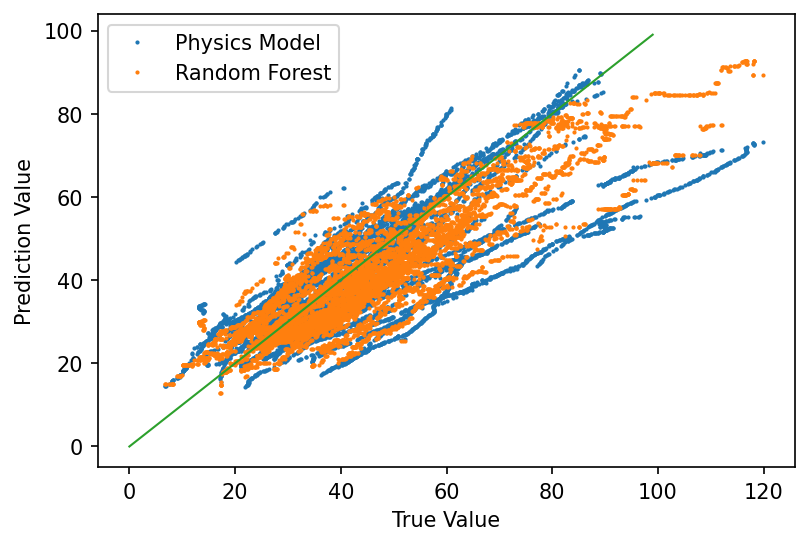

In [45]:
plt.plot(y_true, y_phy,lineStyle='none',marker='o',markersize=1,label='Physics Model')
plt.plot(y_true,y_gbm,lineStyle='none',marker='o',markersize=1, label='Random Forest')
plt.plot(list(range(0,100)),list(range(0,100)),linewidth=1)
plt.legend()
plt.xlabel('True Value')
plt.ylabel('Prediction Value')

In [46]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
latlon = np.transpose(np.concatenate(([sampled_df2.lat.values],[sampled_df2.lon]),axis=0))
latlon_original=np.transpose(np.concatenate(([df.LatDegree.values],[df.LongDegree.values]),axis=0))

neigh.fit(latlon_original)
distances = neigh.kneighbors(latlon)

In [47]:
sampled_df2.insert(11, 'distance', distances[0]*110.567)

In [48]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,gbm_pred,dnn_pred,distance
0,280048,4700100668,1260,30.361111,39.010401,-80.015406,36.559764,16395,34.458778,36.841774,42.191521,0.916395
1,38195,4708509707,1800,37.872222,39.228950,-81.061086,47.615715,19524,49.052672,56.375664,55.407288,0.004931
2,558997,4700502166,500,26.200000,37.980414,-81.866307,27.455254,16552,30.635910,25.034779,27.062170,0.037135
3,254811,4701705462,2120,61.272222,39.323677,-80.768249,73.130694,17240,73.369919,64.696358,63.911308,0.014114
4,492235,4707700185,1670,42.233333,39.562450,-79.746017,51.146633,19036,58.003417,59.569466,50.912998,0.000049
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,358066,4708300103,1710,69.077778,38.707282,-79.969042,78.234521,19185,45.036128,52.104946,51.821686,12.912729
9996,239017,4701304647,830,26.144444,38.947304,-81.088589,29.583737,16797,37.807192,28.057423,30.445650,0.007011
9997,365976,4708300103,2920,96.600000,38.707282,-79.969042,113.616499,19185,68.449077,91.476990,88.833572,12.912729
9998,21788,4709100479,2010,60.722222,39.400064,-80.106135,71.830490,19588,74.844388,64.293938,63.547501,0.002048


In [49]:
sampled_df2
sampled_df2['avgd_model'] = sampled_df2[['physics_pred', 'gbm_pred', 'dnn_pred']].mean(axis=1)

In [50]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,gbm_pred,dnn_pred,distance,avgd_model
0,280048,4700100668,1260,30.361111,39.010401,-80.015406,36.559764,16395,34.458778,36.841774,42.191521,0.916395,37.830691
1,38195,4708509707,1800,37.872222,39.228950,-81.061086,47.615715,19524,49.052672,56.375664,55.407288,0.004931,53.611875
2,558997,4700502166,500,26.200000,37.980414,-81.866307,27.455254,16552,30.635910,25.034779,27.062170,0.037135,27.577619
3,254811,4701705462,2120,61.272222,39.323677,-80.768249,73.130694,17240,73.369919,64.696358,63.911308,0.014114,67.325862
4,492235,4707700185,1670,42.233333,39.562450,-79.746017,51.146633,19036,58.003417,59.569466,50.912998,0.000049,56.161960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,358066,4708300103,1710,69.077778,38.707282,-79.969042,78.234521,19185,45.036128,52.104946,51.821686,12.912729,49.654253
9996,239017,4701304647,830,26.144444,38.947304,-81.088589,29.583737,16797,37.807192,28.057423,30.445650,0.007011,32.103421
9997,365976,4708300103,2920,96.600000,38.707282,-79.969042,113.616499,19185,68.449077,91.476990,88.833572,12.912729,82.919880
9998,21788,4709100479,2010,60.722222,39.400064,-80.106135,71.830490,19588,74.844388,64.293938,63.547501,0.002048,67.561942


<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

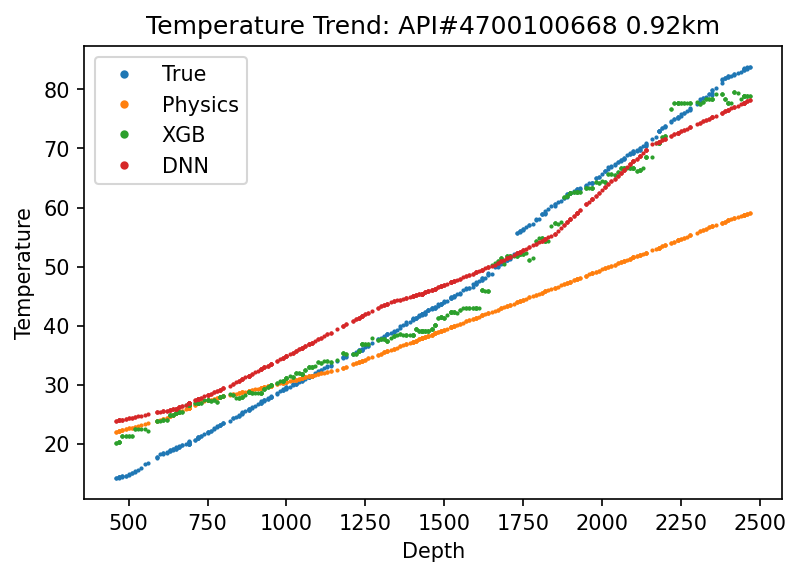

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

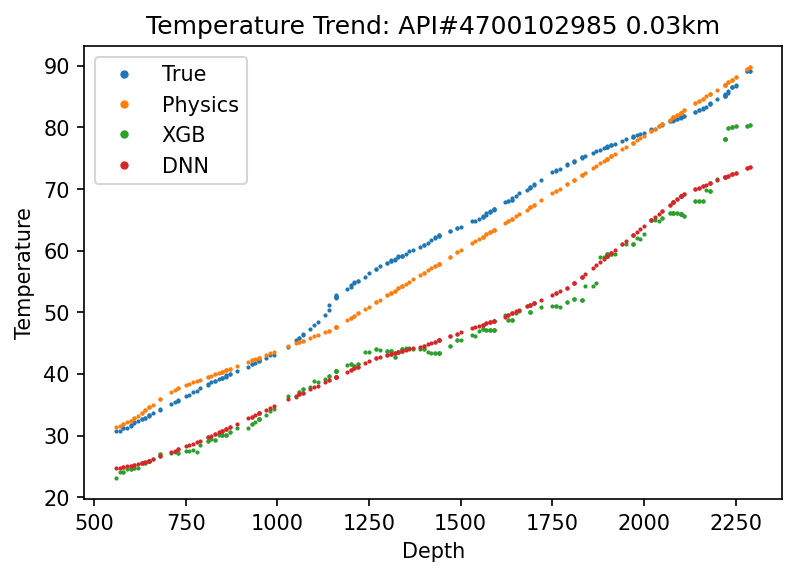

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

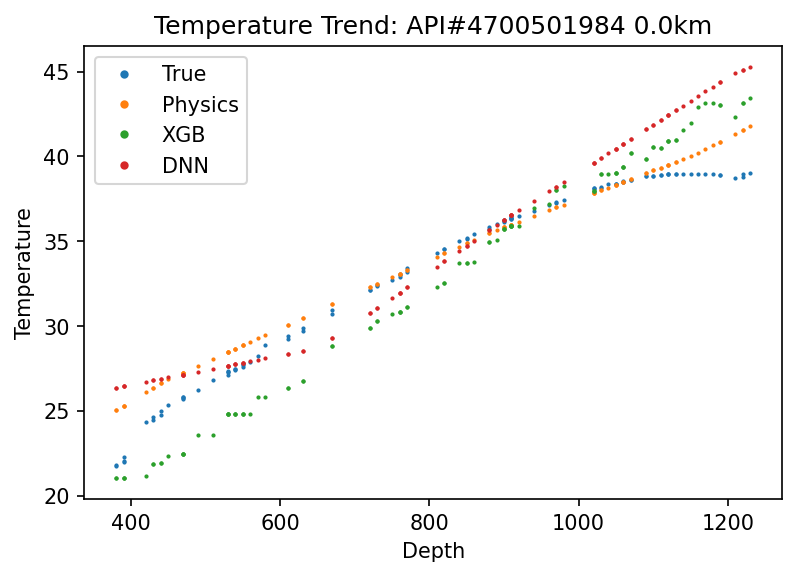

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

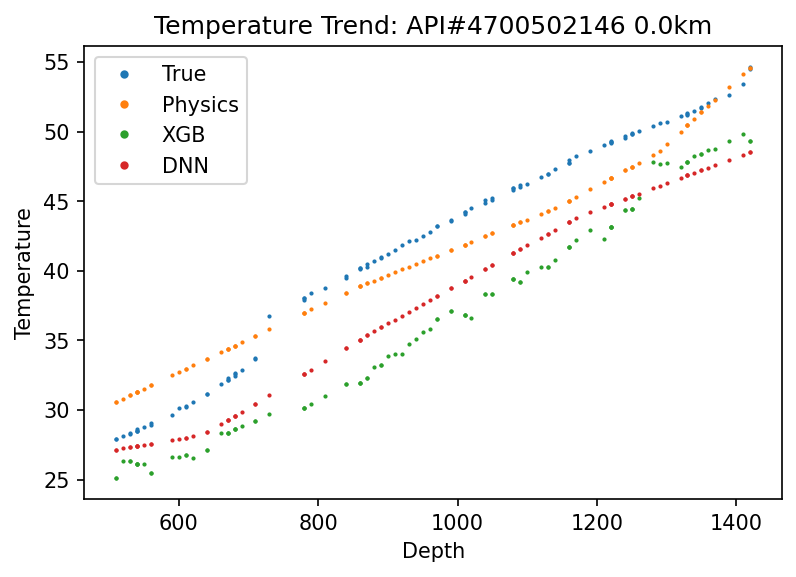

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

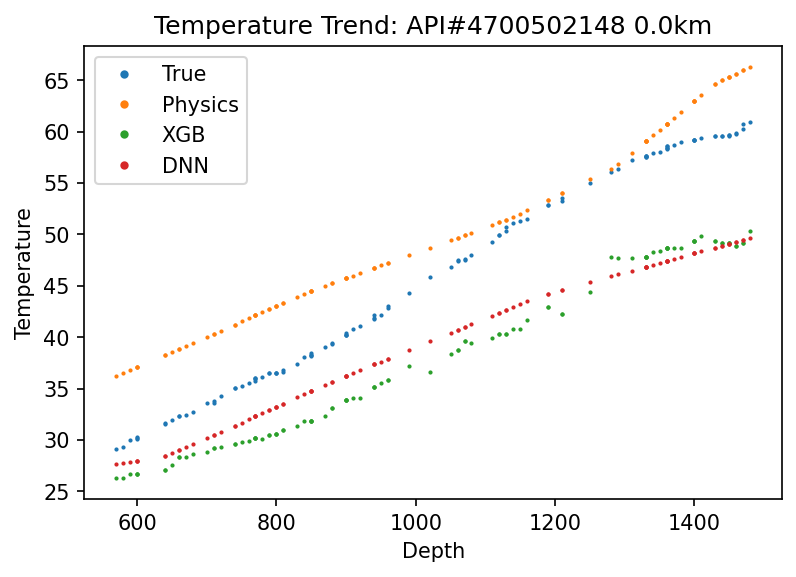

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

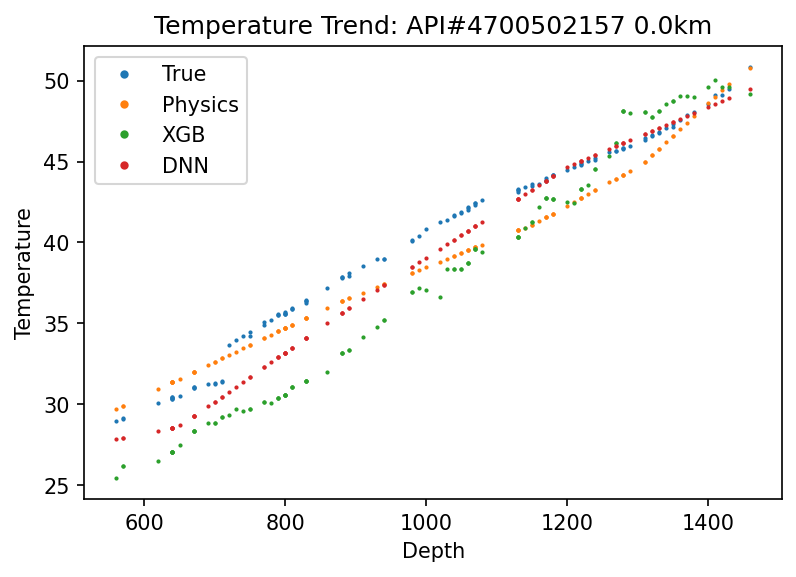

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

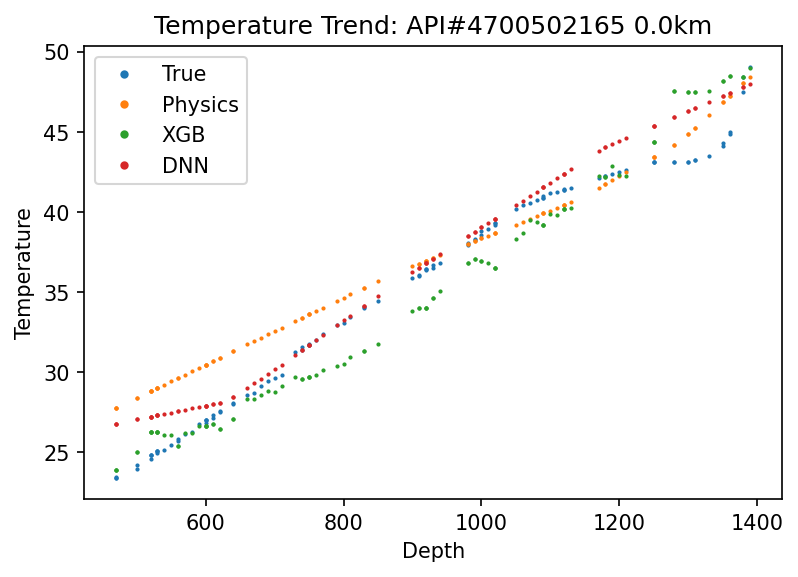

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

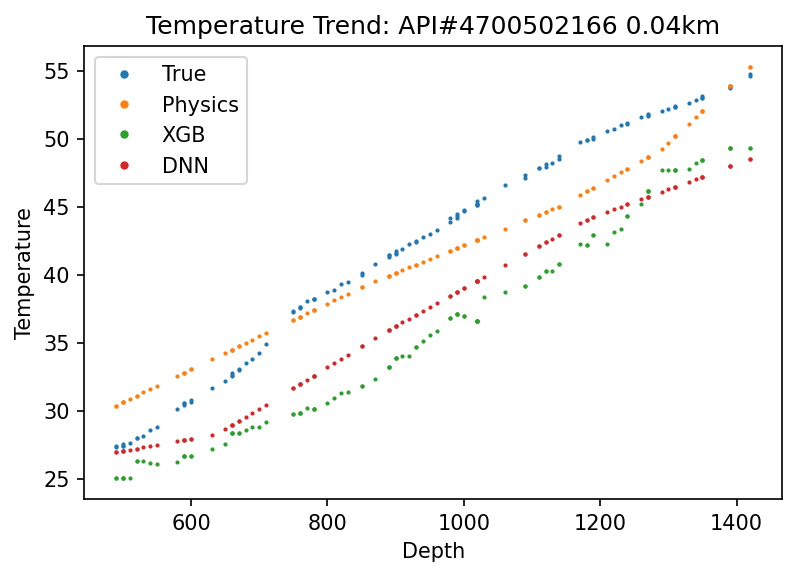

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

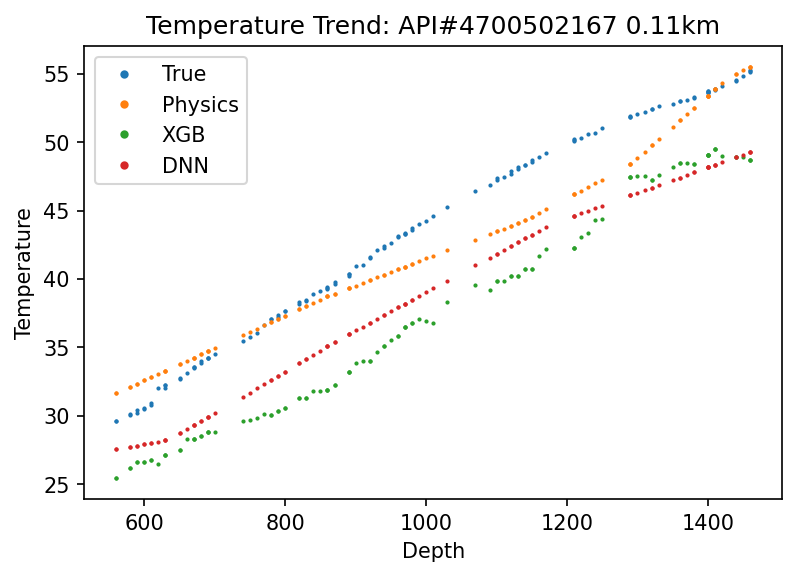

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

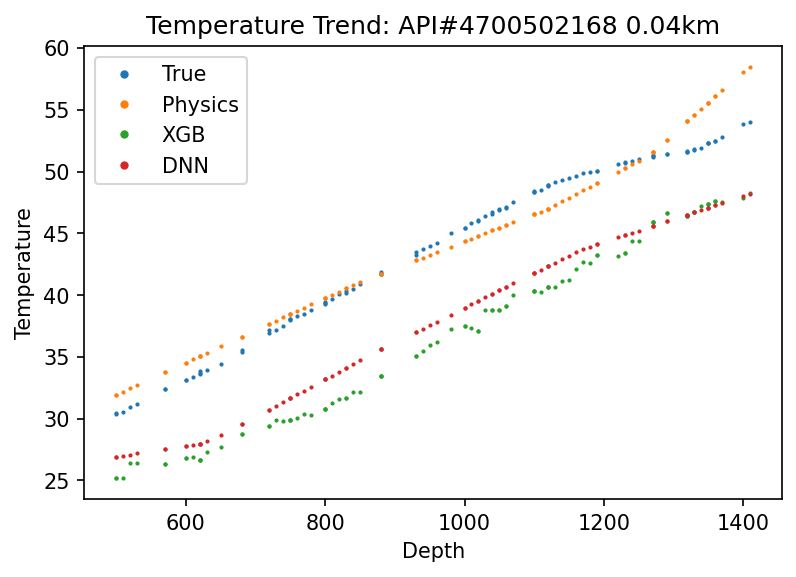

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

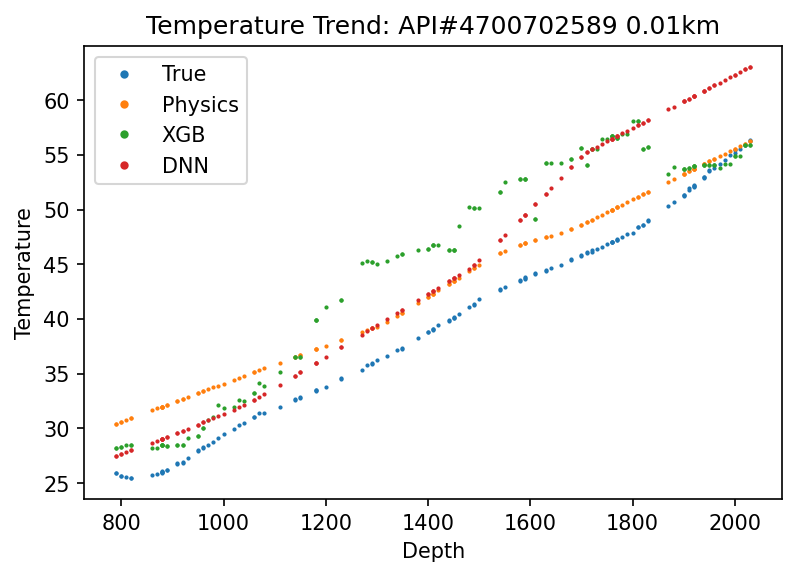

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

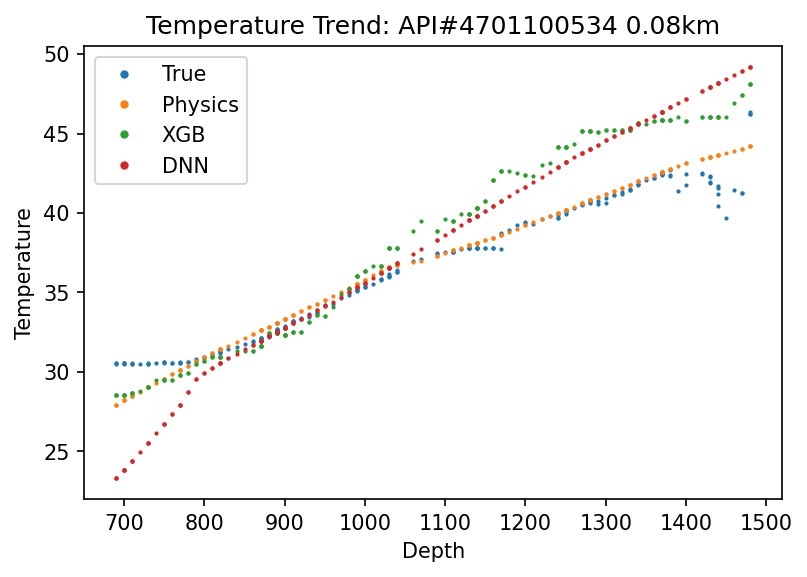

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

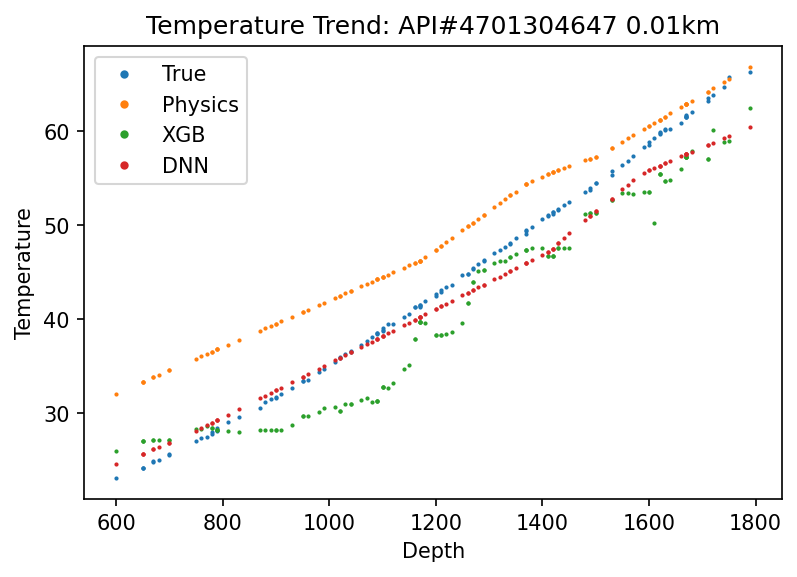

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

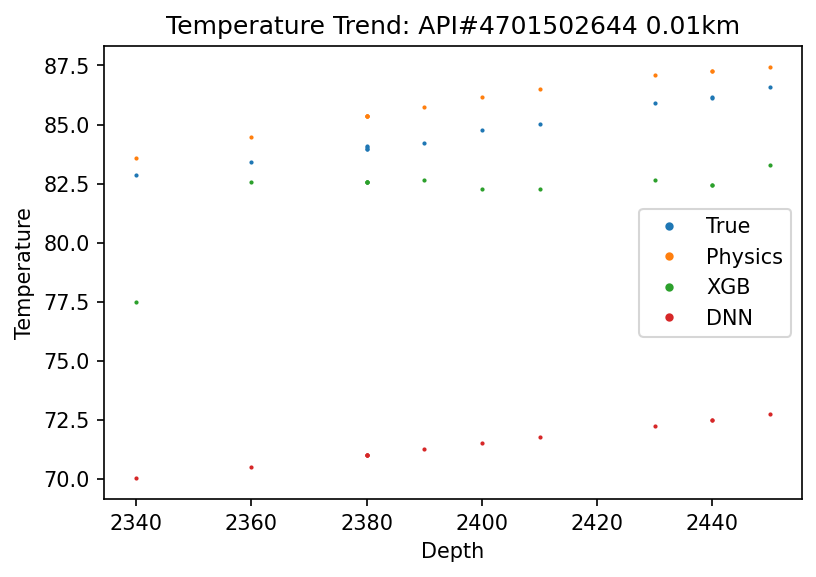

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

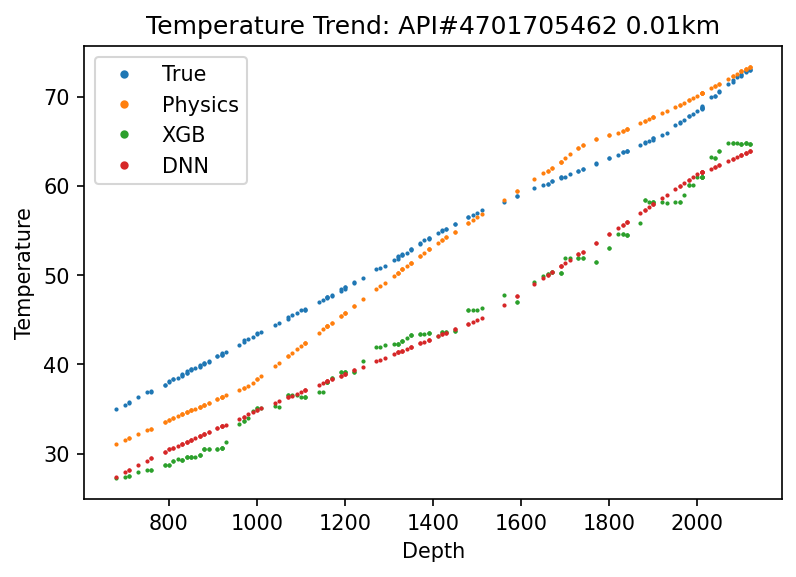

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

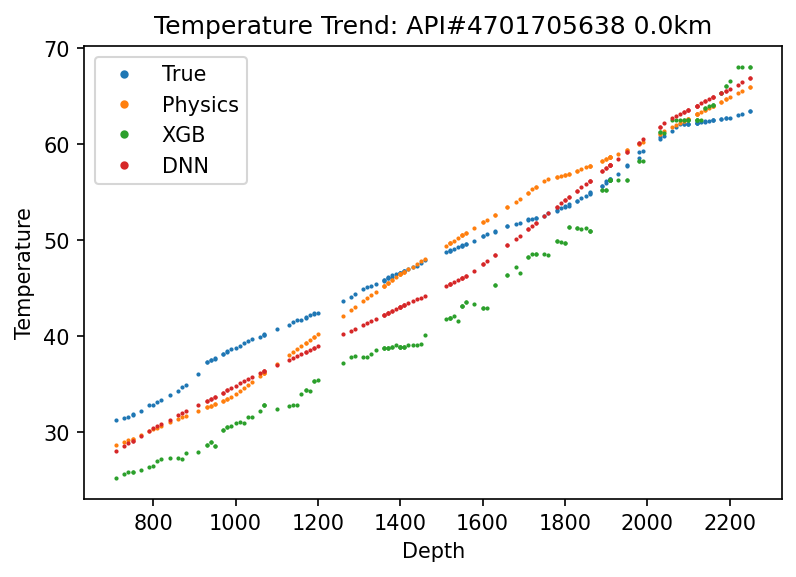

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

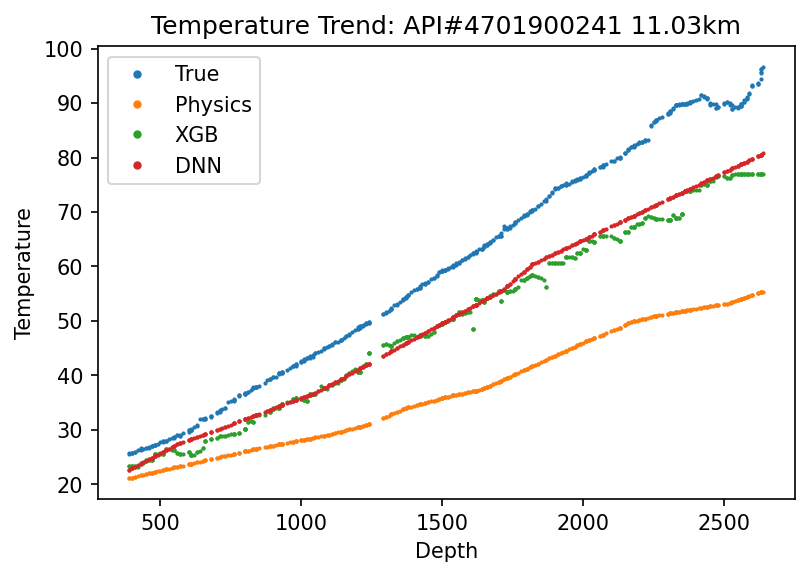

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

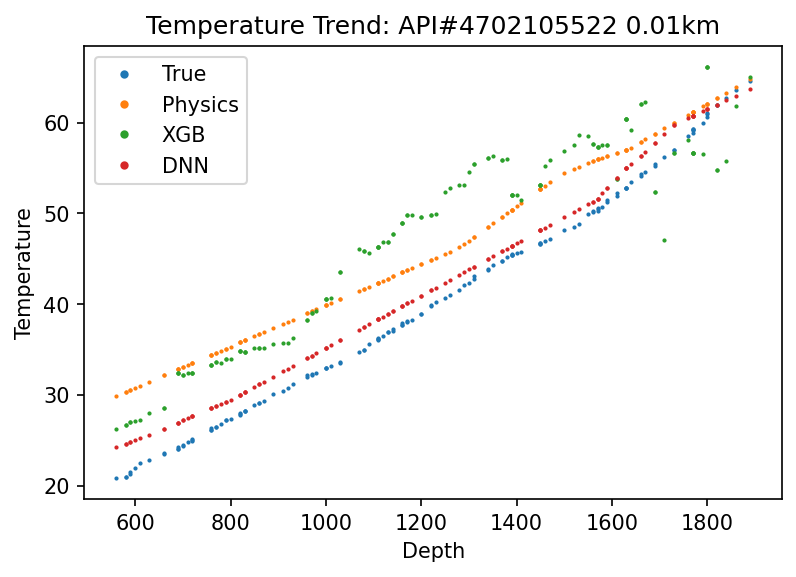

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

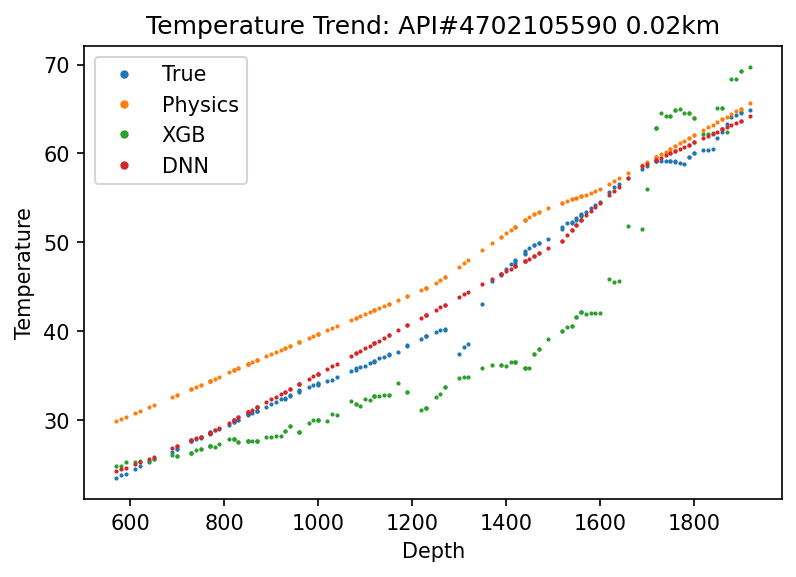

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

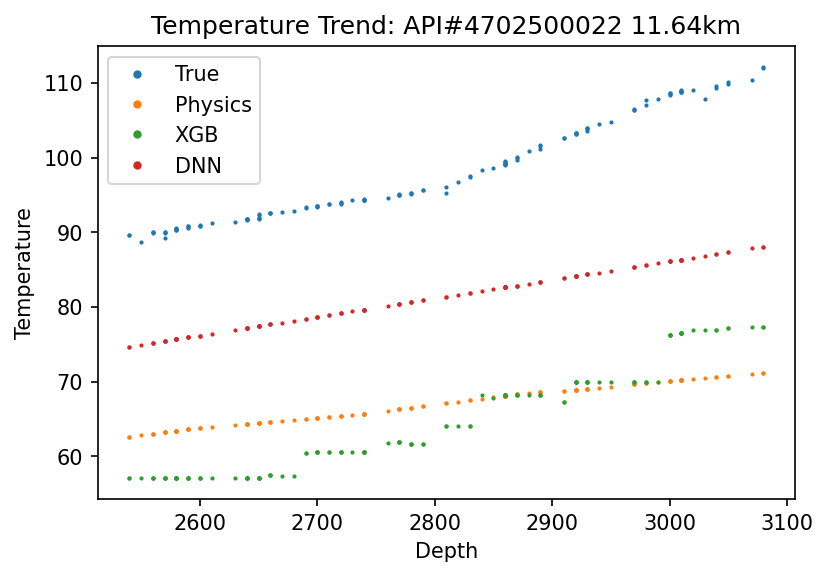

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

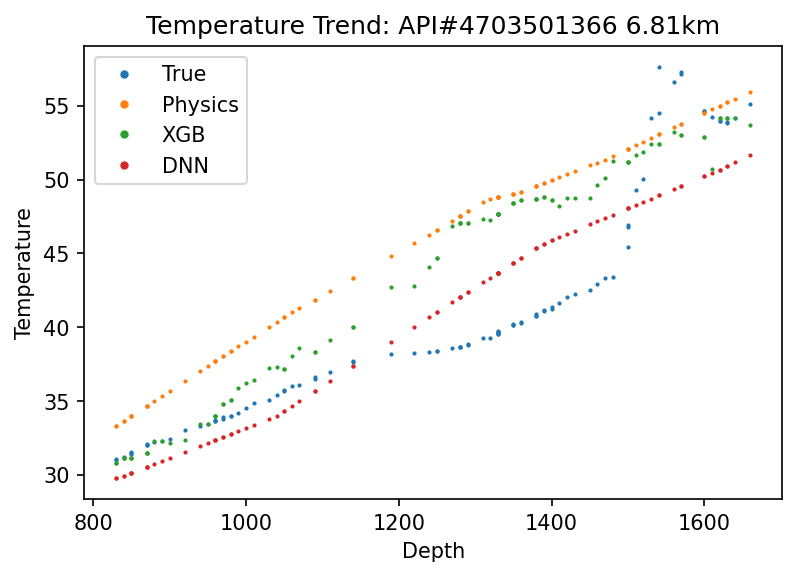

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

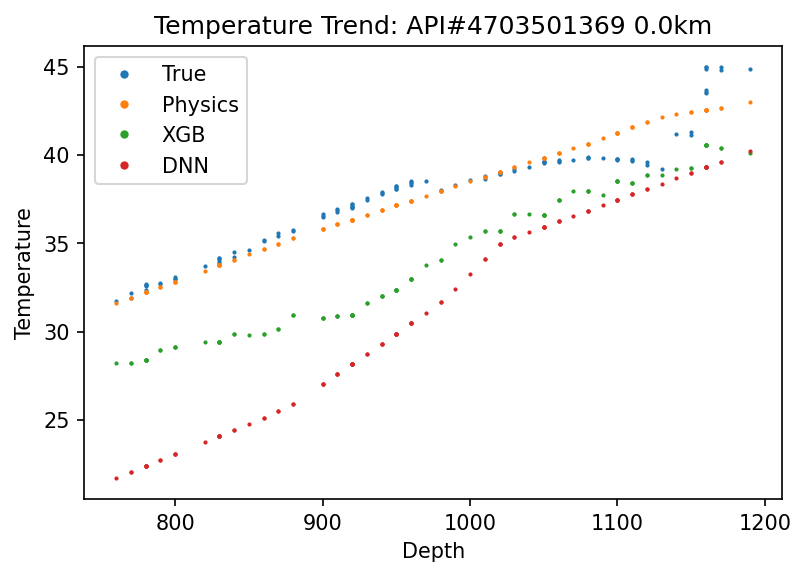

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

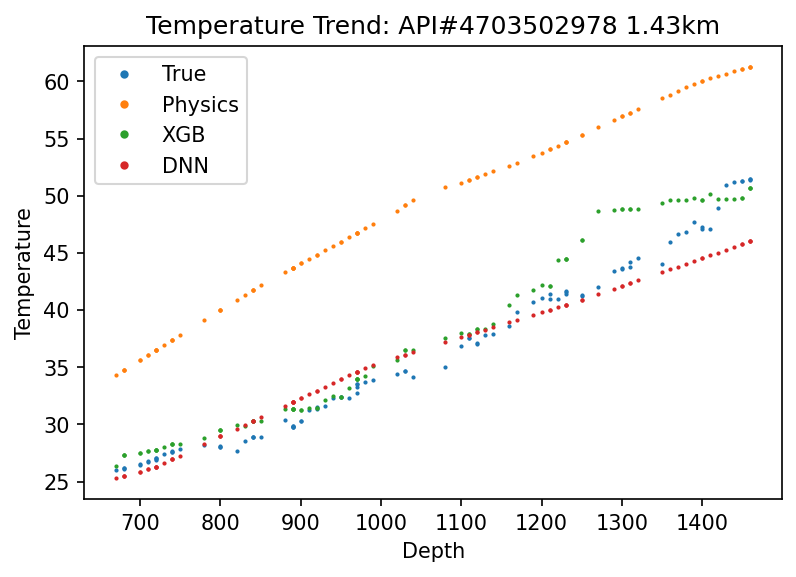

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

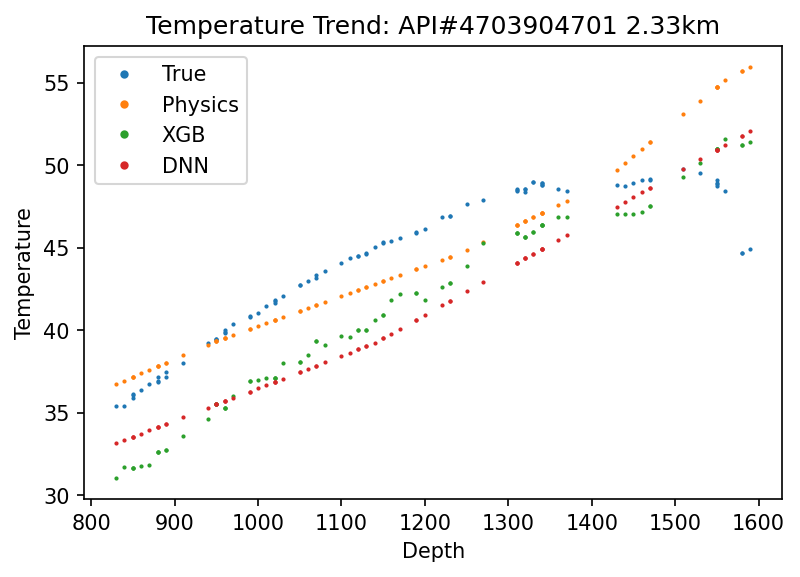

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

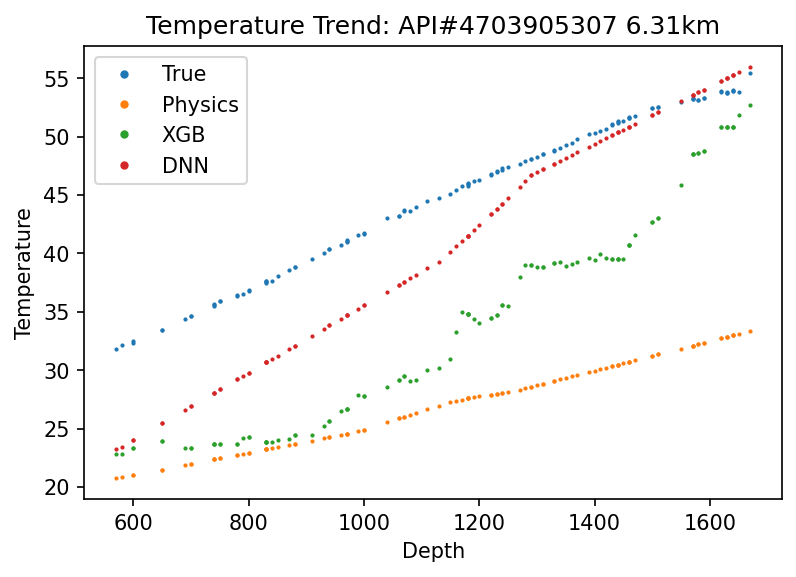

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

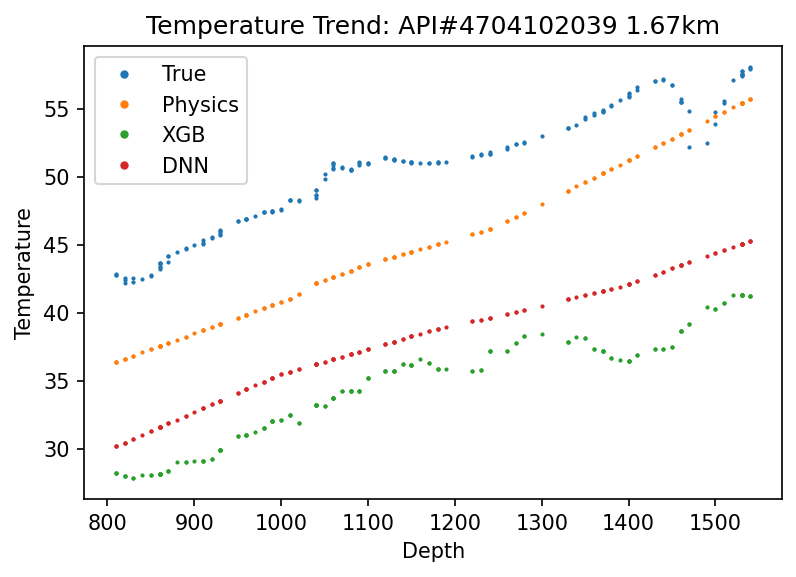

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

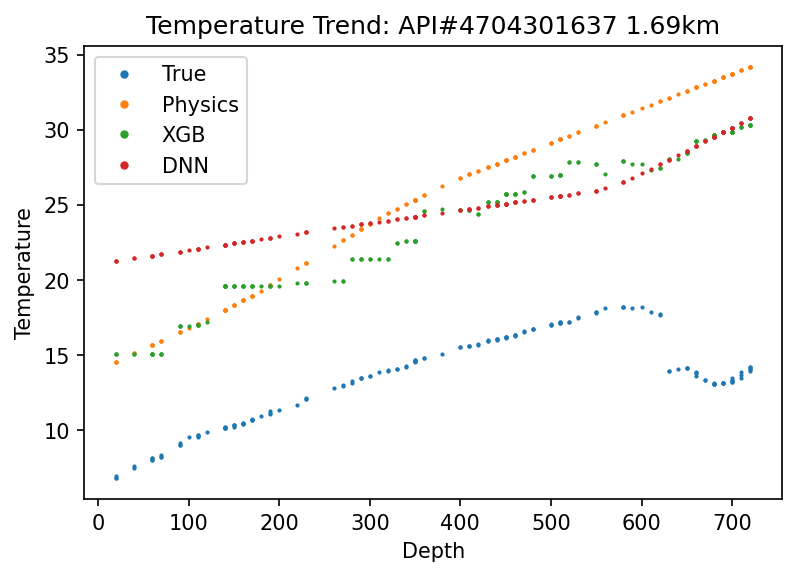

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

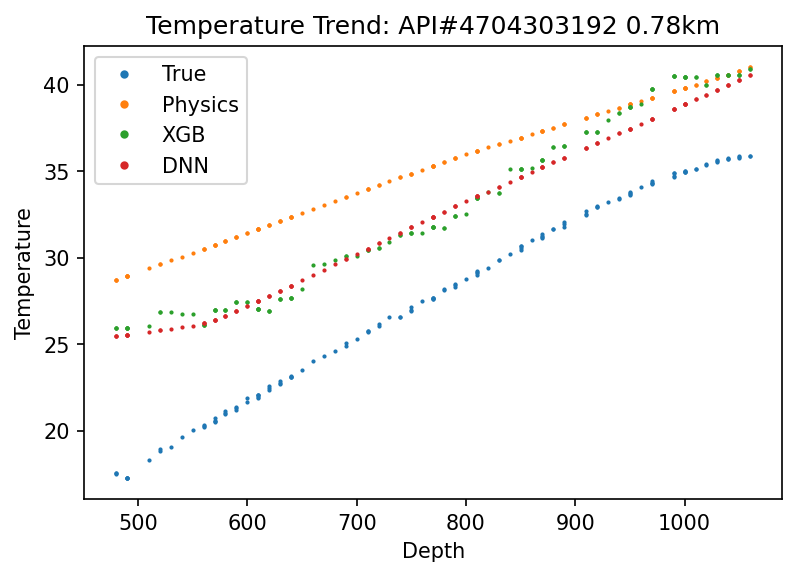

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

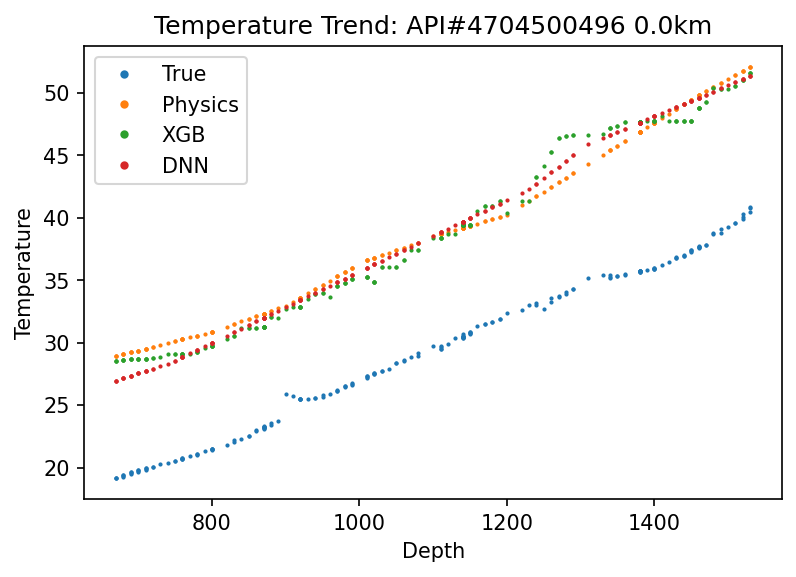

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

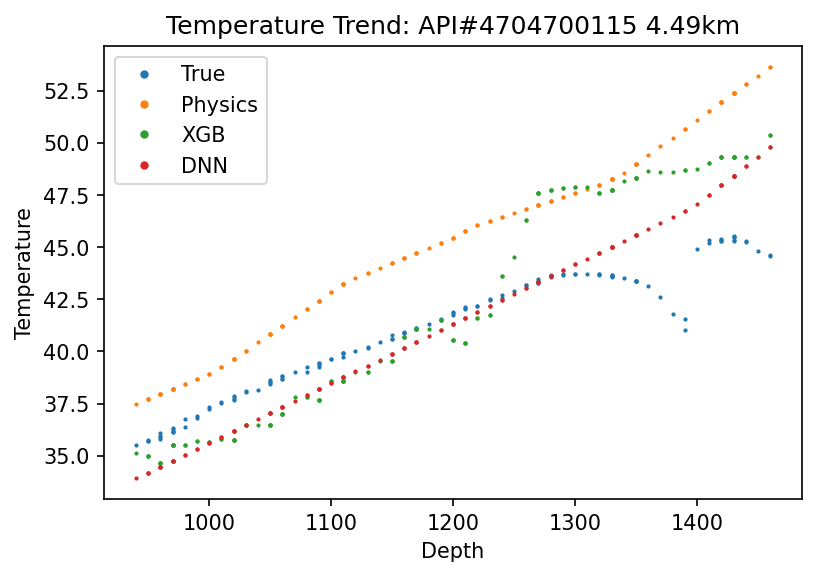

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

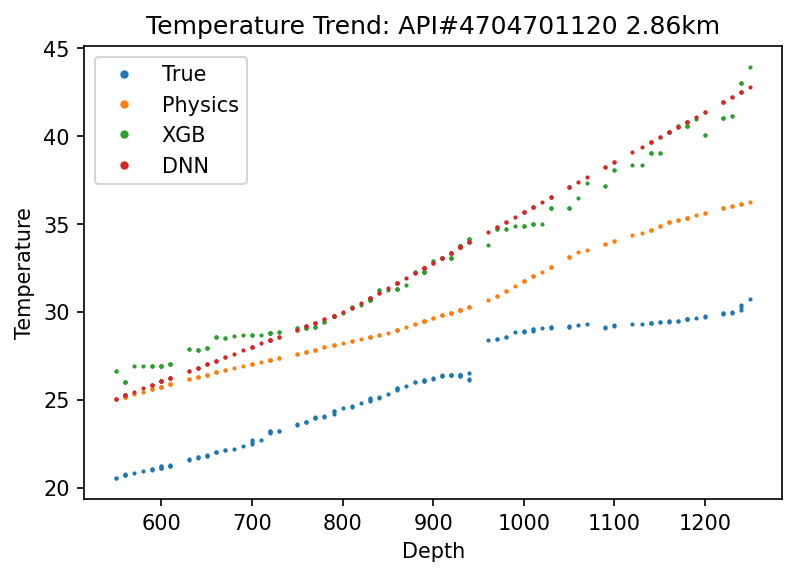

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

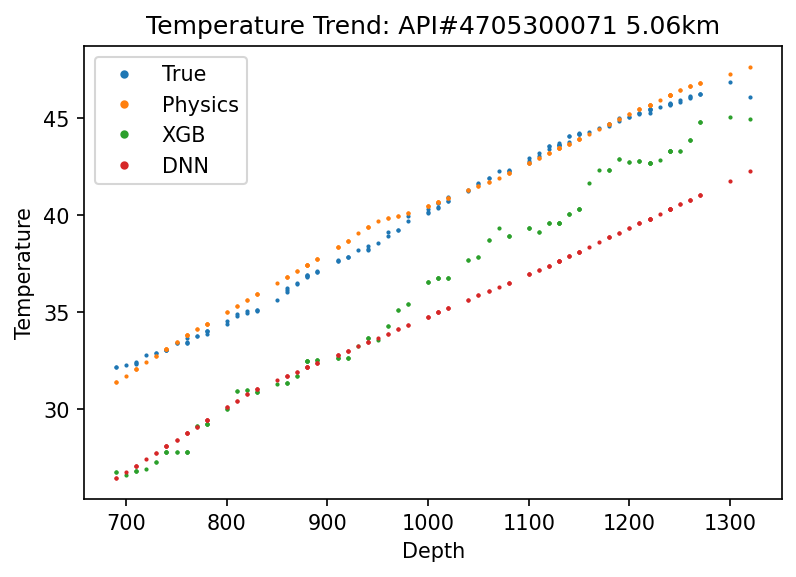

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

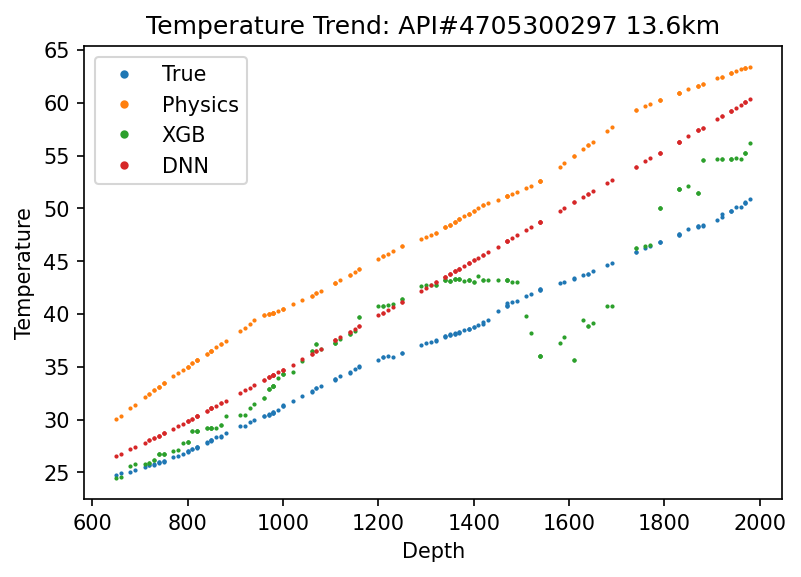

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

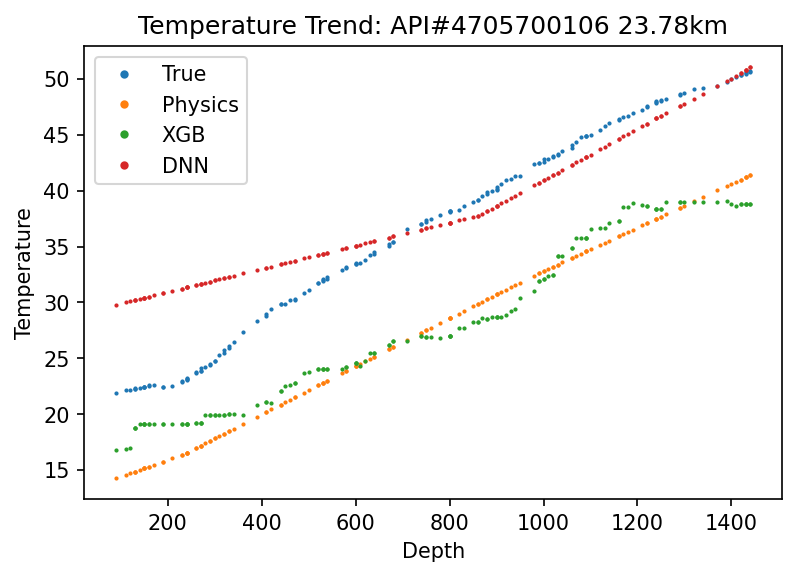

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

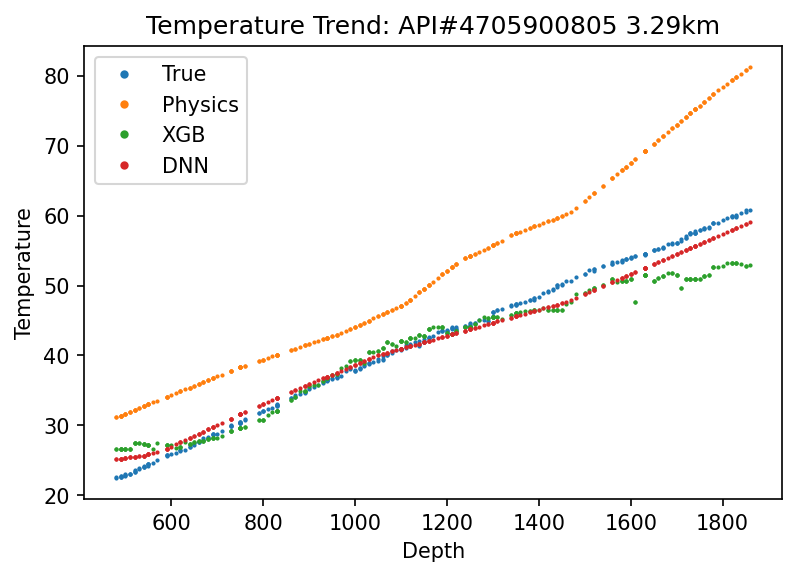

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

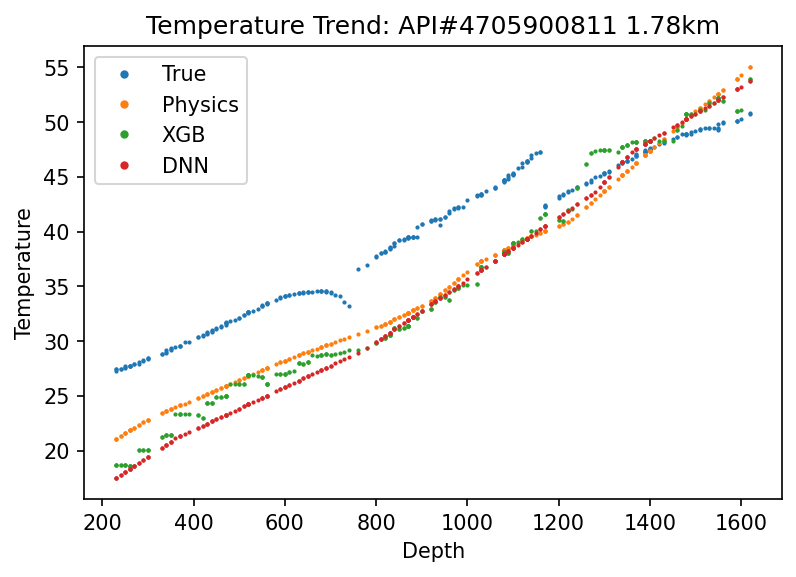

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

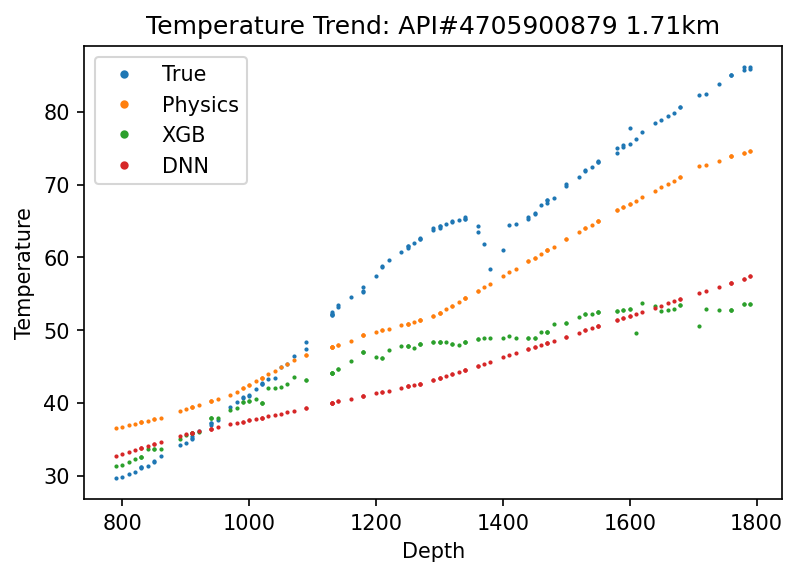

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

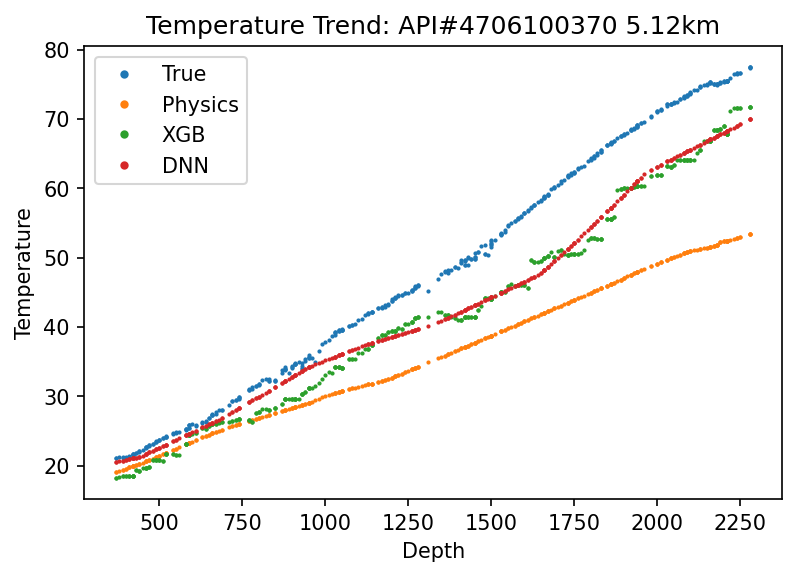

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

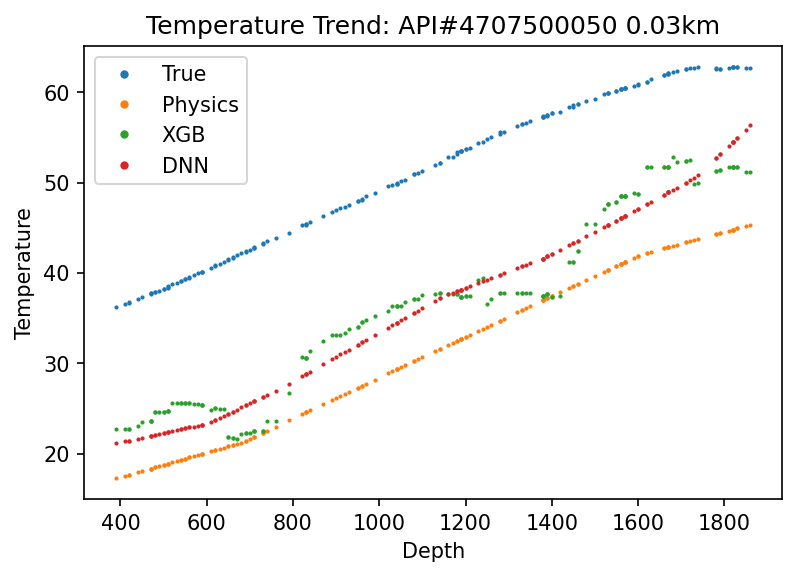

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

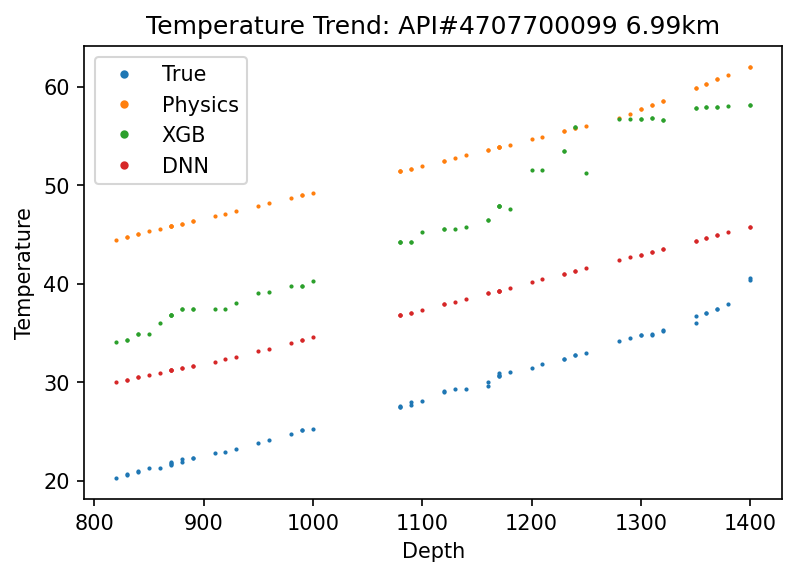

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

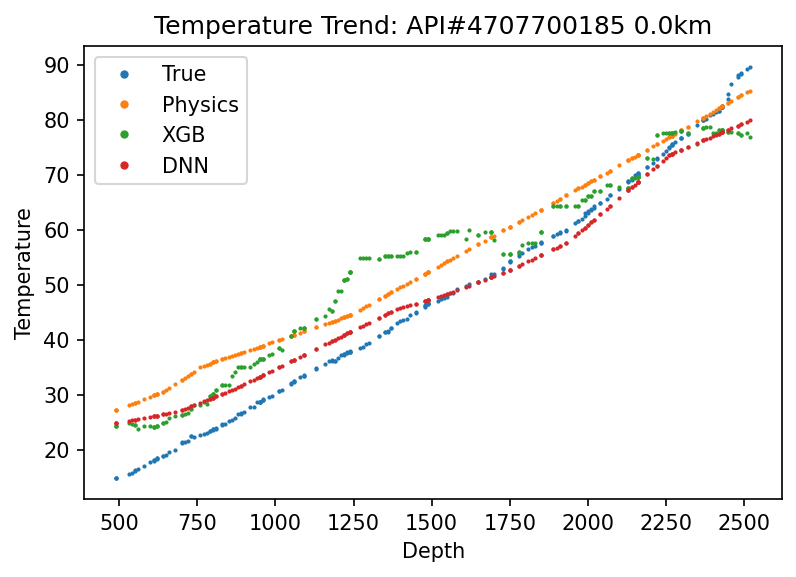

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

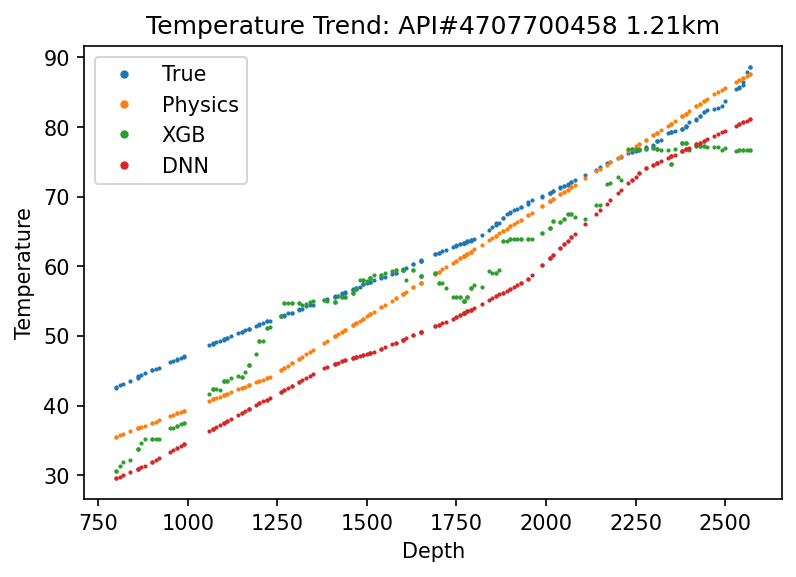

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

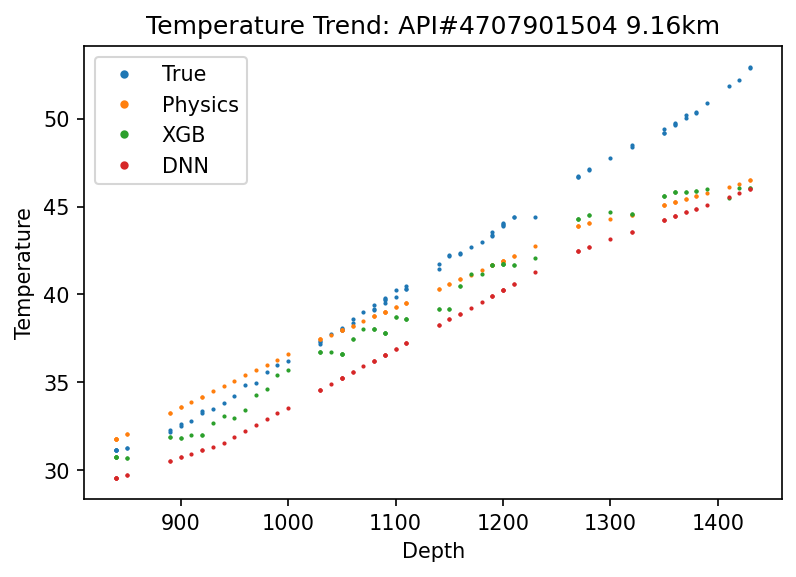

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

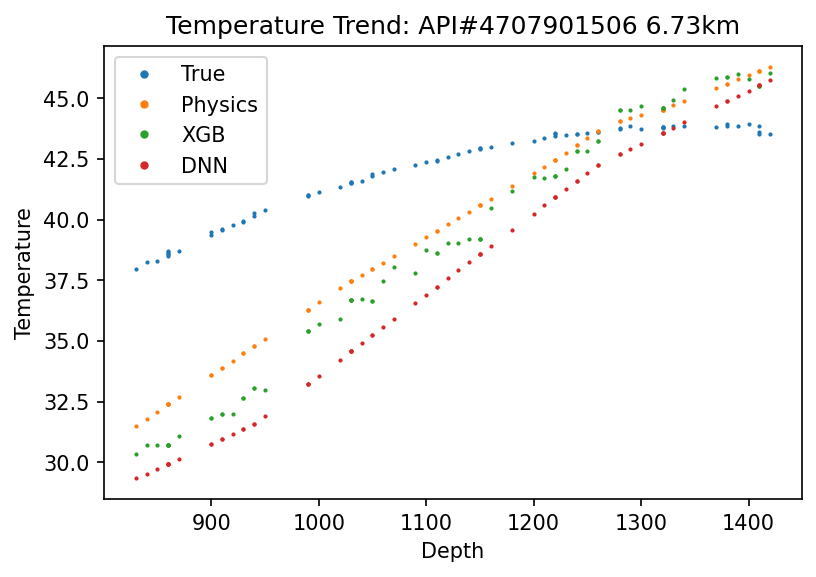

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

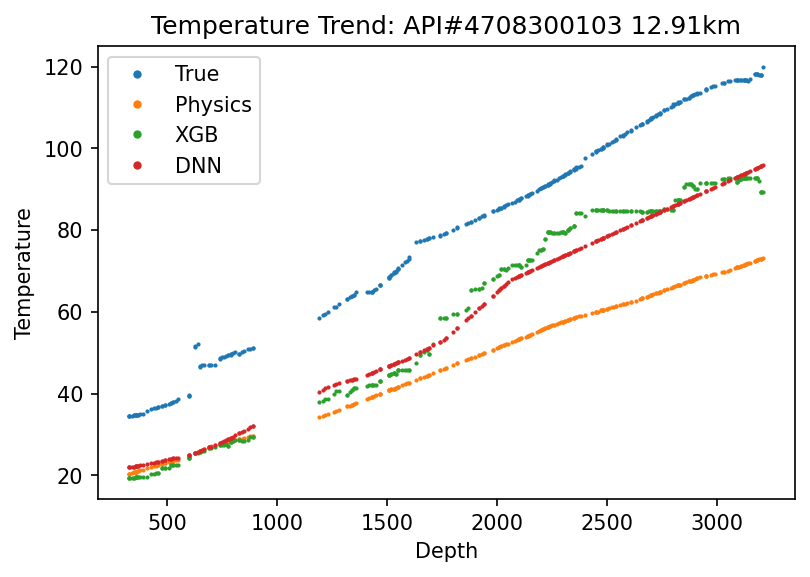

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

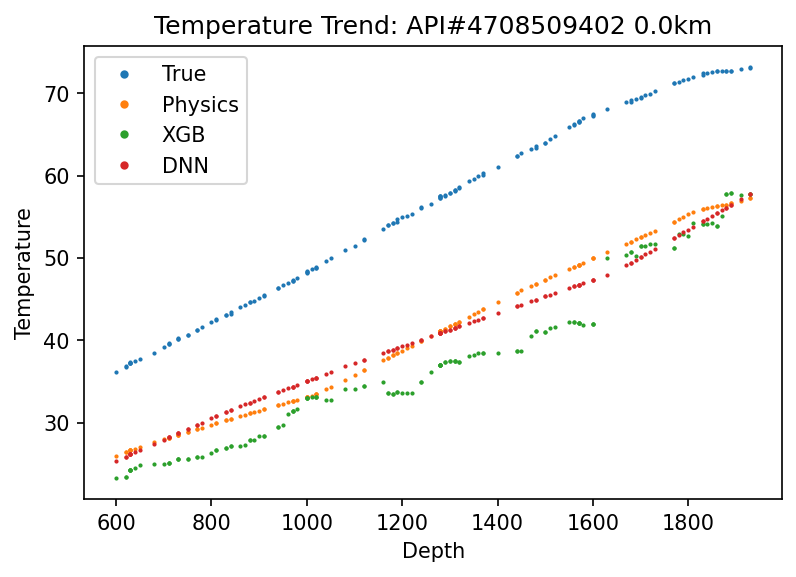

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

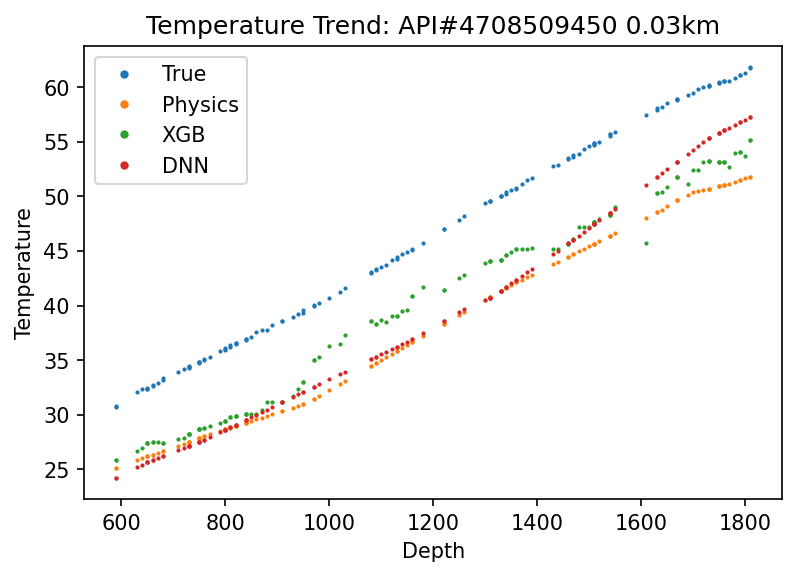

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

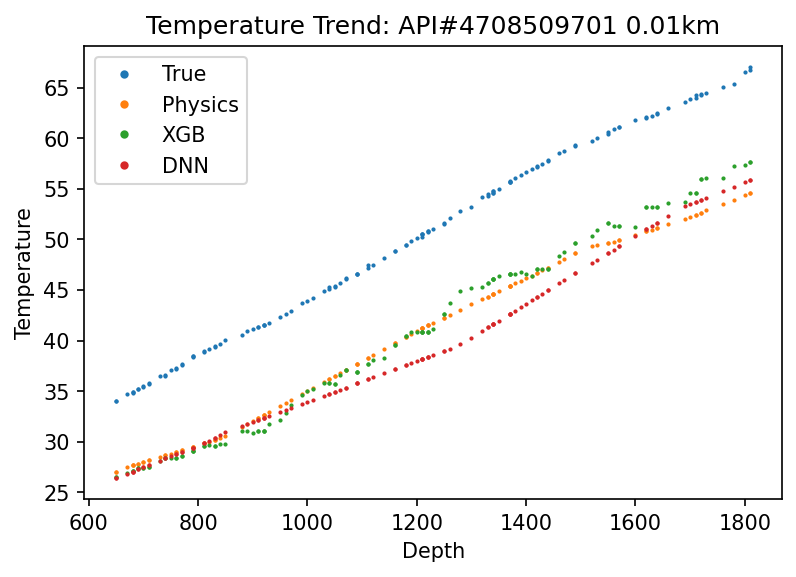

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

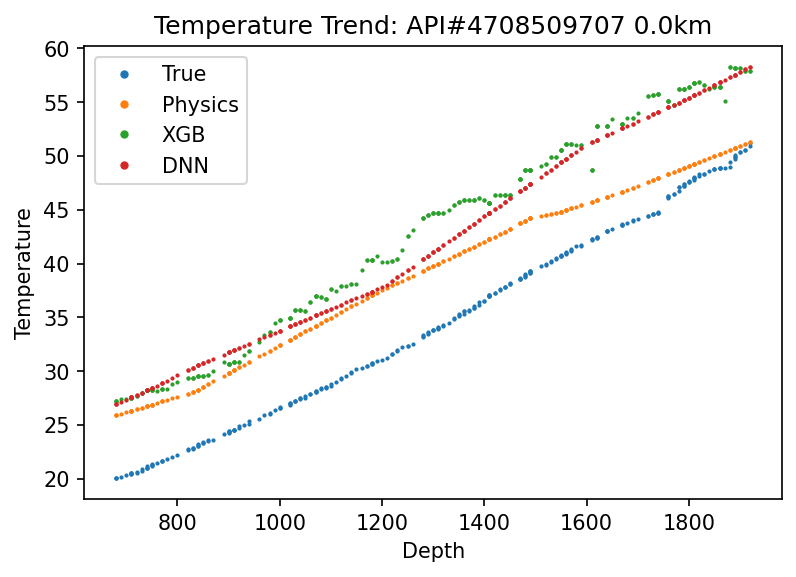

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

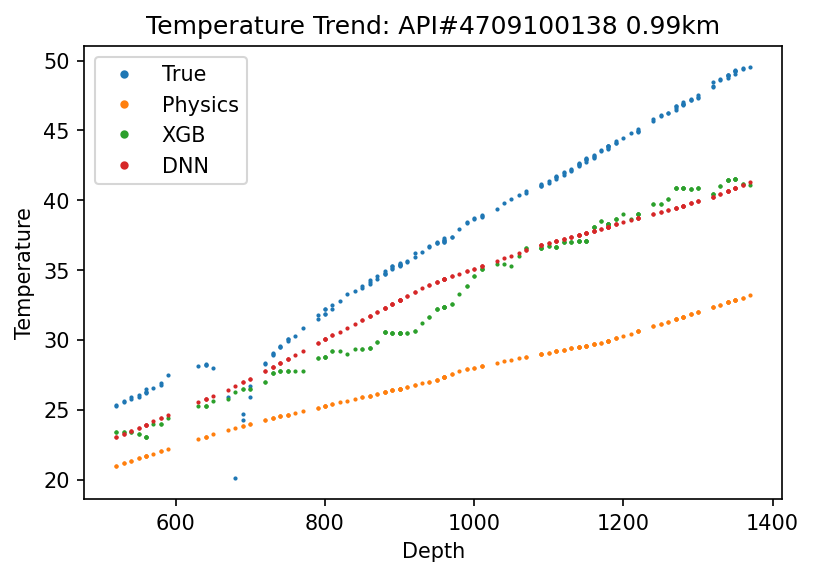

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

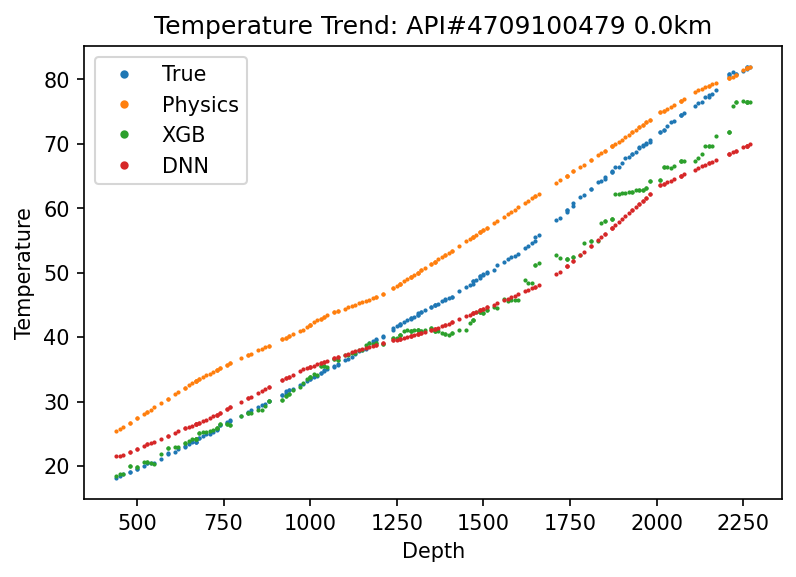

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

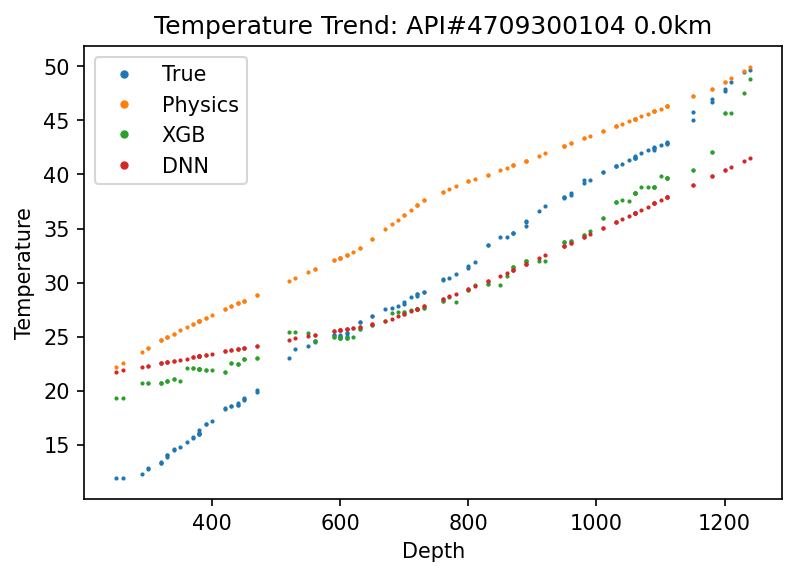

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

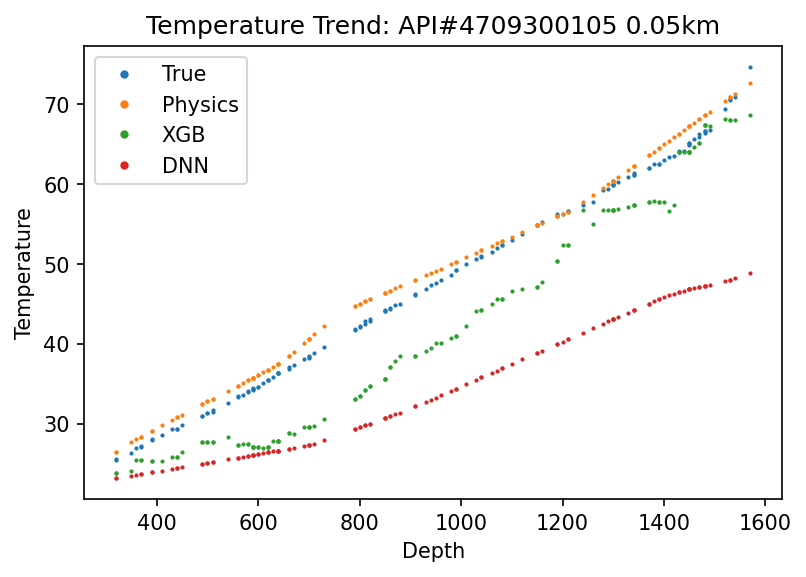

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

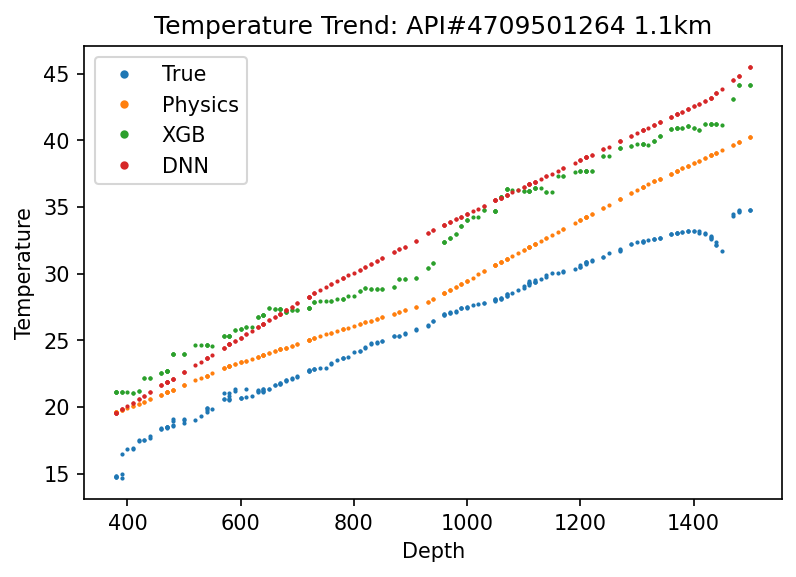

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

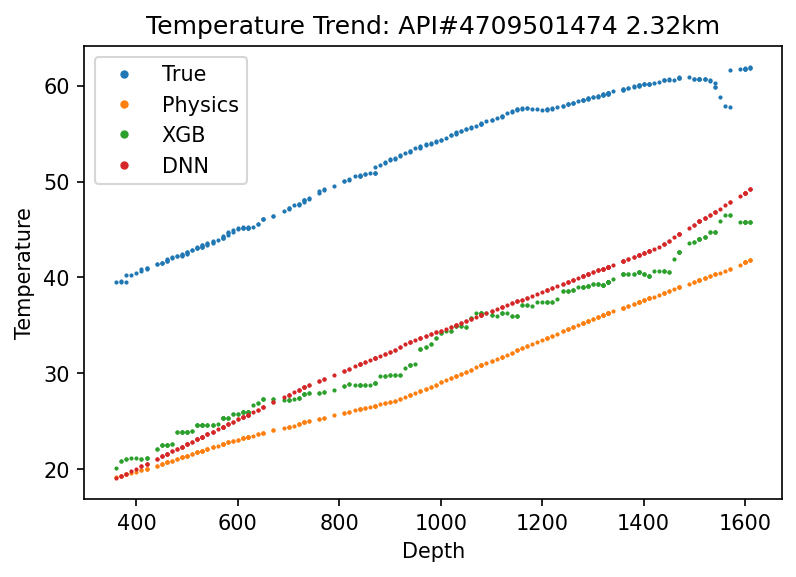

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

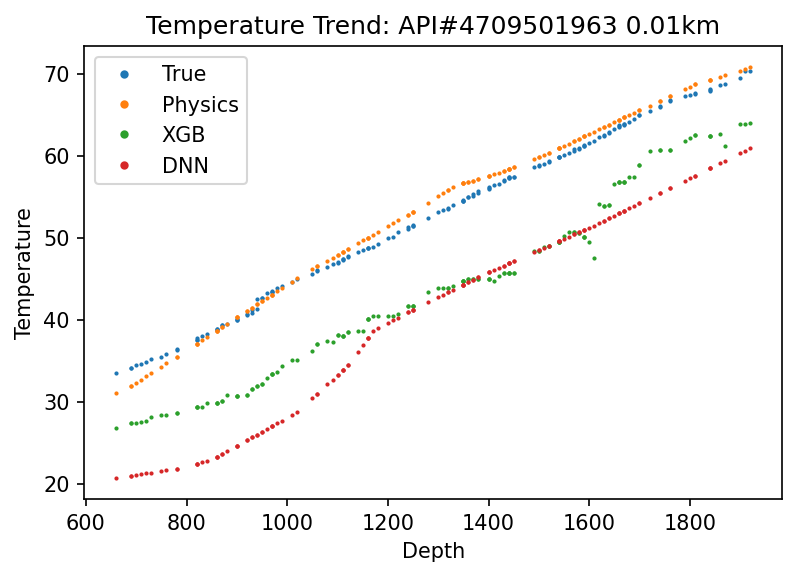

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

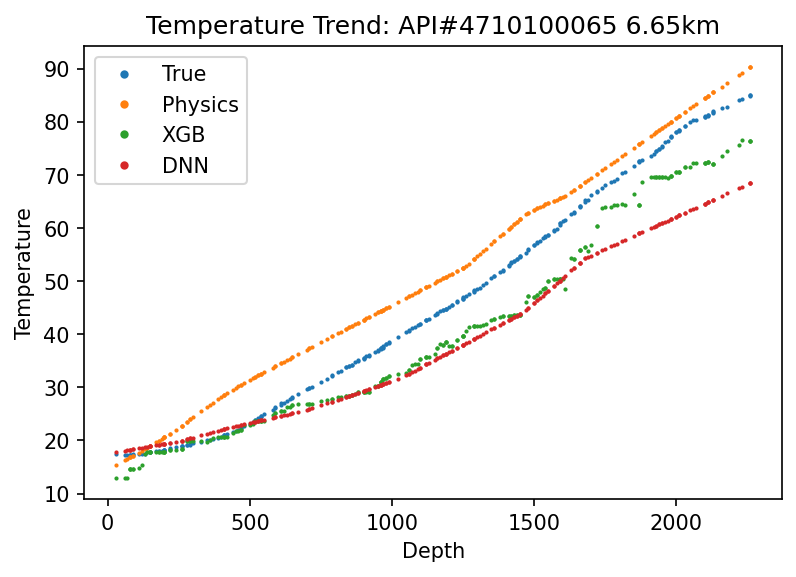

<ipython-input-51-91ef08f7c63f>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
<ipython-input-51-91ef08f7c63f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
<ipython-input-51-91ef08f7c63f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
<ipython-input-51-91ef08f7c63f>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',marke

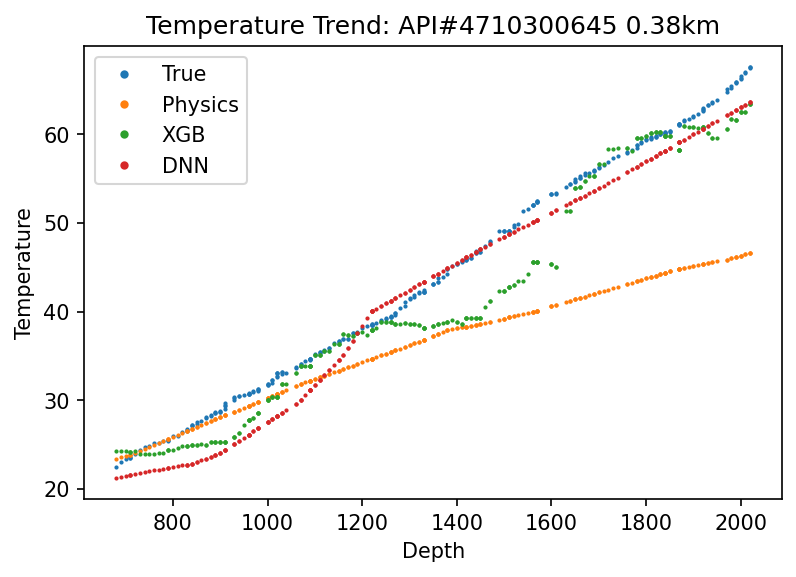

In [51]:
for curr_id in np.unique(sampled_df2.id):
    ms = 2
    y_true = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['corrtemp']
    y_physics = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['physics_pred']
    y_gbm = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['gbm_pred']
    y_dnn = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['dnn_pred']
    y_avgd = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['avgd_model']
    depth_hat = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['depth']
    plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
    plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
    plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
    plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',markersize=ms, label='DNN')
    #plt.plot(depth_hat,y_avgd,lineStyle='none',marker='.',markersize=ms, label='Ensemble')

    lgd = plt.legend()
    lgd.legendHandles[0]._legmarker.set_markersize(6)
    lgd.legendHandles[1]._legmarker.set_markersize(6)
    lgd.legendHandles[2]._legmarker.set_markersize(6)
    lgd.legendHandles[3]._legmarker.set_markersize(6)
    plt.xlabel('Depth')
    plt.ylabel('Temperature')
    curr_dist = sampled_df2[sampled_df2.id==curr_id].distance.values[0]
    plt.title('Temperature Trend: API#'+str(curr_id) + ' '+str(round(curr_dist,2)) + 'km')
    plt.show()